# **PART III:** Autoencoders for Anomaly Detection [40 pts]

In this part of our assignment, we will implement autoencoder and explore it’s application for anomaly detection.

**NOTE:** The min accuracy to be achieved for this task is 80%.

## **Datasets**

Below is a list of datasets. Select ONE dataset based on your preference:

- [Yahoo S5 Dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70): real server logs from a popular web service, containing various anomalies such as spikes, dips, and shifts in user traffic

- [Hard Drive Test Data](https://www.kaggle.com/datasets/backblaze/hard-drive-test-data): daily snapshot of each operational hard drive.

- [Numenta Anomaly Benchmark](https://www.kaggle.com/boltzmannbrain/nab): tweets about airline experiences, labeled with sentiment.

- [Stanford Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/): movie reviews classified as positive or negative.

- [Medical Dialogue Dataset](https://www.kaggle.com/datasets/xuehaihe/medical-dialogue-dataset): contains conversations (in English) between doctors and patients. It has 0.26 million dialogues.

- [News Headlines Dataset](https://www.kaggle.com/rmisra/news-category-dataset): news headlines labeled with sentiment, covering various news topics and categories.

#### QUESTION 0
Which dataset do you choose? Briefly justify your choice (e.g., relevance to your field of study or general interest).

<font color='green'>### YOUR ANSWER HERE ###</font>

I have selected cpu utilization dataset to detect aanomalies. It is more in the point of importance rather than study of interest, cpu utilization is deciding how the parts are working, abnormal cpu utilization can easily detected and corrected.

The dataset is from : Numenta Anomaly Benchmark




## **TASK 1:** Data Exploration & Preprosessing

### **STEP 1:** Main Statistics

Read, preprocess, and print the main statistics about the dataset.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, AdamW
from scipy import stats


In [ ]:
folder_path = 'Numenta Anomaly Benchmark'
filepath = 'ec2_cpu_utilization_5f5533.csv'
data = pd.read_csv(f"{folder_path}/realAWSCloudwatch/realAWSCloudwatch/{filepath}")


In [ ]:
data.describe()


,value
count,4032.000000
mean,43.110372
std,4.303565
min,34.766000
25%,39.296000
50%,42.918000
75%,46.006000
max,68.092000


In [ ]:
data.shape

(4032, 2)

In [ ]:
data.head()

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


In [ ]:
# all_dfs, scaler = load_and_preprocess_data(folder_path)
# for fp, df in all_dfs.items():
#     print(fp)
#     print(df.describe())
#     print('_'*50)

#### QUESTION 1
Provide brief details about the nature of your dataset:

- 1.1 What is it about?

- 1.2 What type of data are we encountering?

- 1.3 How many entries and variables does the dataset comprise?

<font color='green'>### YOUR ANSWER HERE ###</font>

 - 1.1. We have taken the data of CPU utilization. The value of CPU utilizations at different time snaps.
 - 1.2. The data consists of two columns one is the time snap and the other is the numerical value which tells us about the usage of CPU
 - 1.3. The data consists of 4032 entries and two variables.


### **STEP 2:** Clean the Data
Clean and prepare the data for modeling, e.g.:

- Handling missing values

- Normalization

- Feature engineering

In [ ]:
data.isnull().sum() # no handling needed

timestamp    0
value        0
dtype: int64

In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = (data['timestamp'] - data['timestamp'].min()).dt.total_seconds()

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
data.head()

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


### **STEP 3:** Visualize the Data

Use libraries like [matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py) or [seaborn](https://seaborn.pydata.org/), [plotly](https://plotly.com/python/) to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., histograms, time-series plots, scatter plots).

Text(0.5, 1.0, 'Distribution of Values')

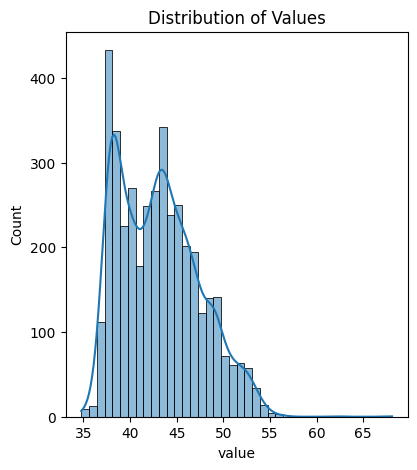

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['value'], kde=True)
plt.title('Distribution of Values')


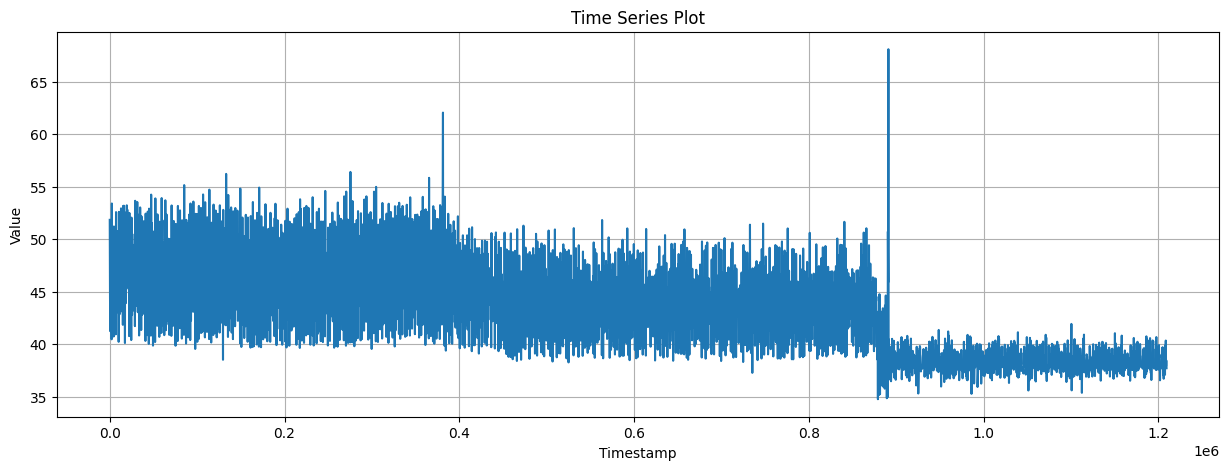

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data['timestamp'], data['value'])
plt.title('Time Series Plot')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.grid(True)
plt.show()

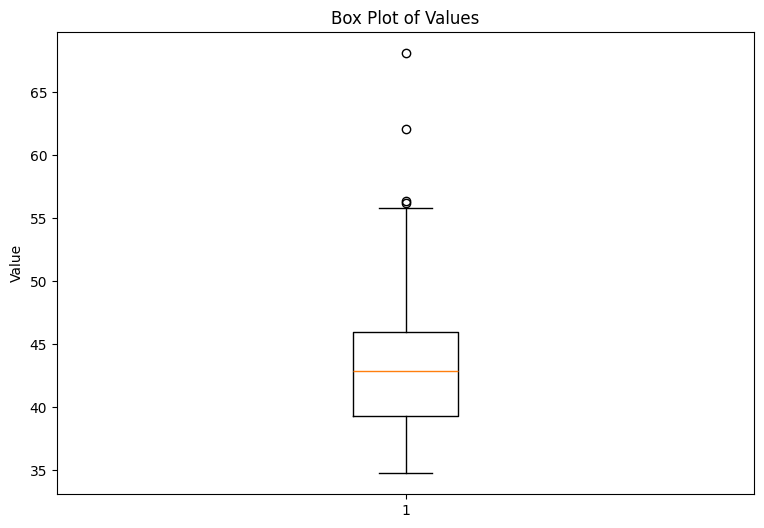

In [ ]:
plt.figure(figsize=(9, 6))
plt.boxplot(data['value'])
plt.title('Box Plot of Values')
plt.ylabel('Value')
plt.show()

### **STEP 4:** Prepare the Datasets

Split the dataset into training, validation and test sets. You can consider using [Cross validation split](https://scikit-learn.org/stable/modules/cross_validation.html)

In [ ]:
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=73939133)

## **TASK 2:** Build an Autoencoder

### **STEP 5:** Implement an Autoencoder

Build a standard [autoencoder](https://arxiv.org/pdf/2003.05991.pdf) or [Variational Autoencoder (VAE)](https://arxiv.org/abs/1606.05908) architecture for anomaly detection.

In [ ]:
### YOUR CODE HERE ###
def dense_autoencoder(input_dim):
    # input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder


In [ ]:
# def plot_training_history(history, fname):
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    # plt.title(f'Training vs validation loss for {fname}')
    plt.title(f'Training vs validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.tight_layout()
    plt.grid(True)
    plt.show()


In [ ]:
def calculate_anomaly_scores(model, data, threshold, squeeze=False):
    reconstructed = model.predict(data)
    if squeeze:
        reconstructed = np.squeeze(reconstructed)
    mse = np.mean(np.power(data - reconstructed, 2), axis=1)
    return np.mean(mse), mse > threshold


In [ ]:
Encoder = dense_autoencoder( X_train.shape[1])


In [ ]:
Encoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [ ]:
history = Encoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))


Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0819 - val_loss: 0.0735
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0327
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0199
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0137
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0109
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 12/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

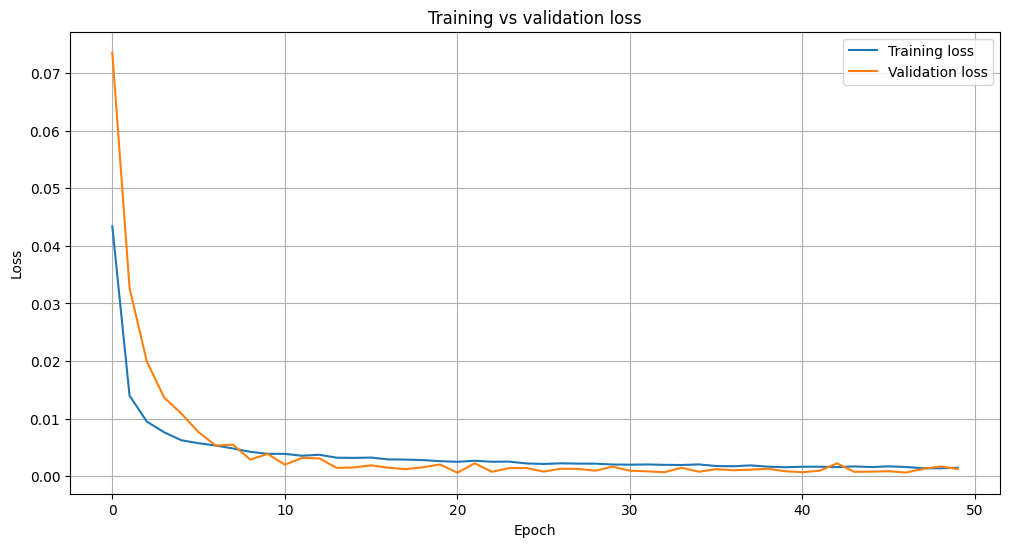

In [ ]:
plot_training_history(history)

In [ ]:
reconstructed_train = Encoder.predict(X_train)
mse_train = np.mean(np.power(X_train - reconstructed_train, 2), axis=1)
threshold = np.percentile(mse_train, 95)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
mse, anomalies = calculate_anomaly_scores(Encoder, X_test, threshold)
print(f"reconstruction error : {mse}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
reconstruction error : 0.0012567326027241282


In [ ]:
X_test_df = pd.DataFrame(X_test)
test_data = data.iloc[X_test_df.index]
test_data['anomaly'] = anomalies
anomalies_detected = test_data[test_data['anomaly']]


/var/folders/6x/m1j3yfvd2w1cm6zs4szyh4r00000gn/T/ipykernel_53159/988510744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['anomaly'] = anomalies


In [ ]:
print(f"Number of anomalies detected: {len(anomalies_detected)}")
print("\nSample of detected anomalies:")
print(anomalies_detected.head())
print(f"Anomaly percentage : {len(anomalies_detected)/len(X_test)}")

Number of anomalies detected: 34

Sample of detected anomalies:
    timestamp   value  anomaly
1       300.0  44.508     True
2       600.0  41.244     True
27     8100.0  50.774     True
43    12900.0  52.940     True
74    22200.0  40.774     True
Anomaly percentage : 0.042131350681536554


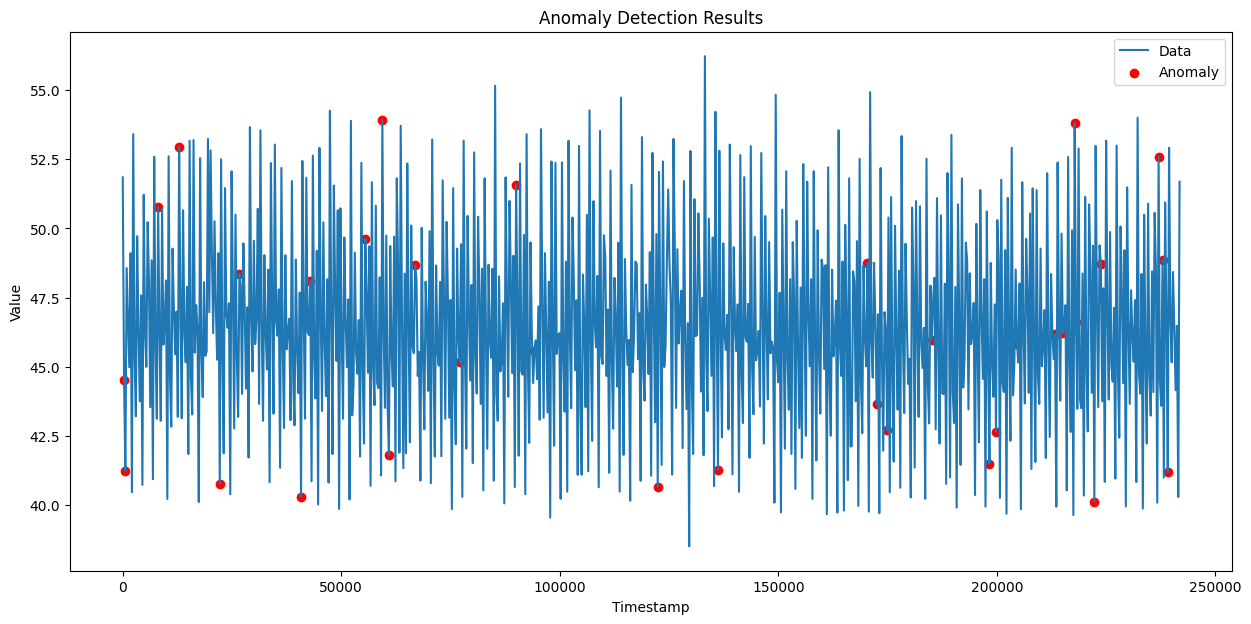

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test_data['timestamp'], test_data['value'], label='Data')
plt.scatter(anomalies_detected['timestamp'], anomalies_detected['value'], color='red', label='Anomaly')
plt.legend()
plt.title('Anomaly Detection Results')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

In [ ]:
Encoder.save('part3_base_model.h5')

### **STEP 6:** Experiment with Architectures

1. Design at least 3 different autoencoders for anomaly detection. Consider experimenting with:

    - Different layer types (Dense, LSTM for time series, Conv1D for sequential data)

    - Number of hidden layers and units

    - Activation functions (ReLU, sigmoid)

2. Choose appropriate evaluation metrics (e.g., reconstruction error, precision-recall) for anomaly classification.

3. Train the autoencoders using **the training set** and use **the validation set** to monitor the performance.

4. Plot the training loss & accuracy over epochs for each model.

5. Plot the validation loss & accuracy over epochs for each model.

6. Report other evaluation metrics such as precision, recall and [F1 score](https://en.wikipedia.org/wiki/F-score) for each model. You may use libraries like [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html).

While you are welcome to experiment with various hyperparameters and setup, please include the three models that return the best result.

#### EXPERIMENT #1

In [ ]:
### YOUR CODE HERE ###
def dense_lstm_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim, 1))
    encoded = LSTM(64, return_sequences=True)(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = LSTM(32, return_sequences=False)(encoded)
    encoded = Dropout(0.2)(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder


In [ ]:

Encoder1 = dense_lstm_autoencoder( X_train.shape[1])

In [ ]:
Encoder1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
history1 = Encoder1.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0982 - val_loss: 0.0098
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 4.2252e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 2.7972e-04
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 3.7419e-04
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 2.2897e-04
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4831e-04 - val_loss: 3.5945e-04
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1839e-04 - val_loss: 3.9951e-04
Epoch 12/50
101/101 

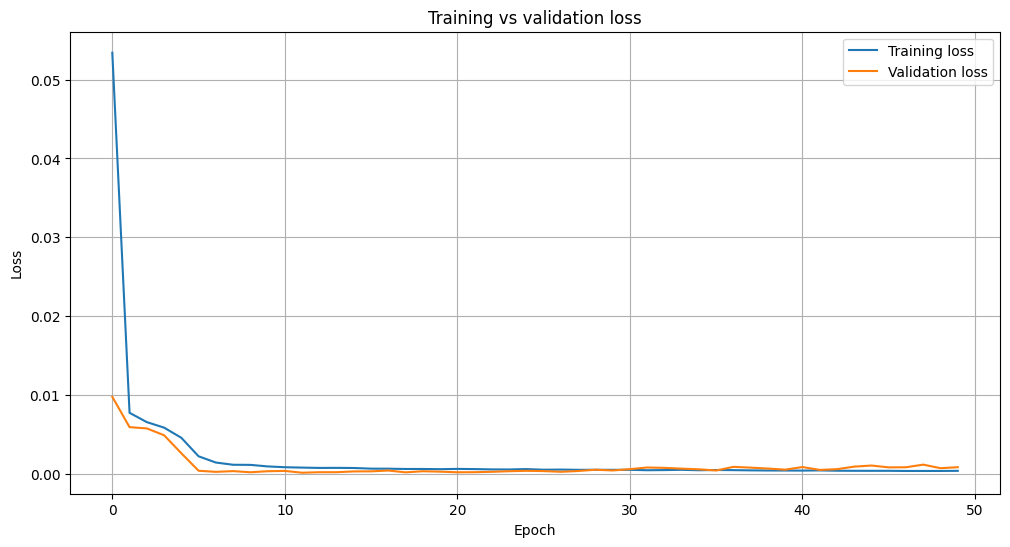

In [ ]:
plot_training_history(history1)


In [ ]:
reconstructed_train = Encoder1.predict(X_train)
mse_train = np.mean(np.power(X_train - reconstructed_train, 2), axis=1)
threshold1 = np.percentile(mse_train, 95)


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
mse1, anomalies1 = calculate_anomaly_scores(Encoder1, X_test, threshold1)
print(f"reconstruction error : {mse1}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
reconstruction error : 0.0008718997315091576


In [ ]:
X_test_df = pd.DataFrame(X_test)
test_data = data.iloc[X_test_df.index]
test_data['anomaly'] = anomalies1
anomalies_detected1 = test_data[test_data['anomaly']]


/var/folders/6x/m1j3yfvd2w1cm6zs4szyh4r00000gn/T/ipykernel_53159/3478674236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['anomaly'] = anomalies1


In [ ]:
print(f"Number of anomalies detected: {len(anomalies_detected1)}")
print("\nSample of detected anomalies:")
print(anomalies_detected1.head())
print(f"Anomaly percentage : {len(anomalies_detected1)/len(X_test)}")


Number of anomalies detected: 40

Sample of detected anomalies:
    timestamp   value  anomaly
2       600.0  41.244     True
19     5700.0  50.224     True
27     8100.0  50.774     True
43    12900.0  52.940     True
74    22200.0  40.774     True
Anomaly percentage : 0.04956629491945477


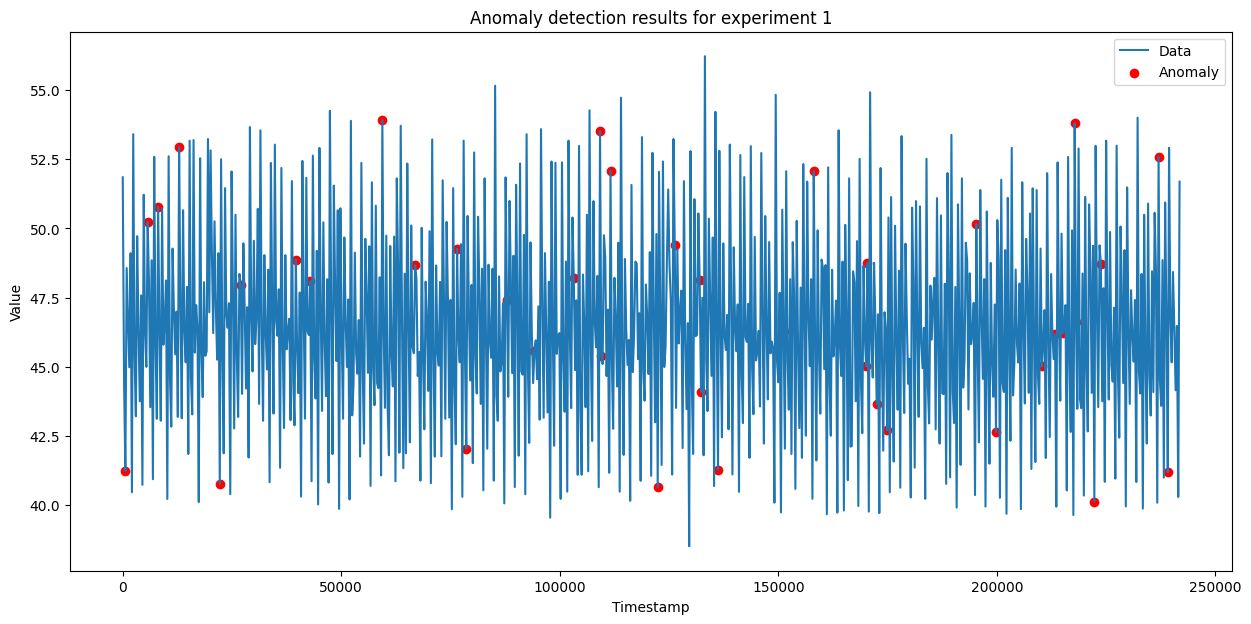

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test_data['timestamp'], test_data['value'], label='Data')
plt.scatter(anomalies_detected1['timestamp'], anomalies_detected1['value'], color='red', label='Anomaly')
plt.legend()
plt.title('Anomaly detection results for experiment 1')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

In [ ]:
Encoder1.save('part3_experiment1_model.h5')

#### EXPERIMENT #2

In [ ]:
### YOUR CODE HERE ###
def dense_conv1d_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim, 1))
    encoded = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
    encoded = Conv1D(32, 3, activation='relu', padding='same')(encoded)
    encoded = Flatten()(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32 * input_dim, activation='relu')(encoded)
    decoded = Reshape((input_dim, 32))(decoded)
    decoded = Conv1D(64, 3, activation='relu', padding='same')(decoded)
    decoded = Conv1D(1,3, activation='linear', padding='same')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder


In [ ]:
# run_all_data(dense_lstm_autoencoder, 'dense_conv1d_model')


In [ ]:
Encoder2 = dense_conv1d_autoencoder( X_train.shape[1])

In [ ]:
Encoder2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
history2 = Encoder2.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0706 - val_loss: 0.0012
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8165e-04 - val_loss: 2.2152e-05
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1209e-05 - val_loss: 1.0313e-05
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8515e-06 - val_loss: 6.7085e-06
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2121e-06 - val_loss: 6.1277e-06
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8318e-06 - val_loss: 4.9040e-06
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0800e-06 - val_loss: 4.4210e-06
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9043e-07 - val_loss: 4.0323e-06
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1792e-07 - val_loss: 4.2104e-06
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2896e-07 - val_loss: 3.5220e-06
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0553

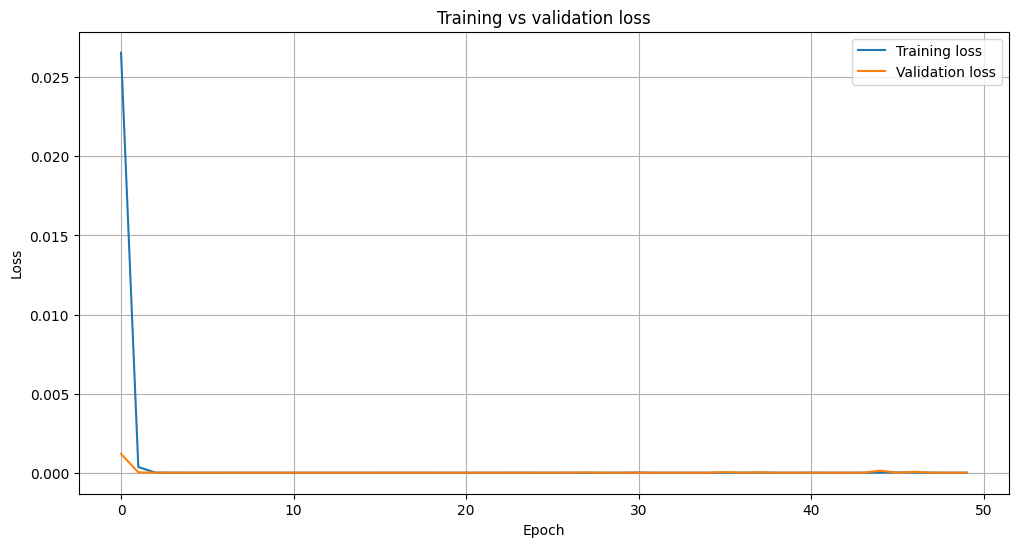

In [ ]:
plot_training_history(history2)

In [ ]:
reconstructed_train2 = Encoder2.predict(X_train)
reconstructed_train2.shape


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(3225, 2, 1)

In [ ]:
reconstructed_train2 = np.squeeze(reconstructed_train2)
X_train.shape


(3225, 2)

In [ ]:

mse_train = np.mean(np.power(X_train - reconstructed_train2, 2), axis=1)
threshold2 = np.percentile(mse_train, 95)
X_test.shape


(807, 2)

In [ ]:
mse2, anomalies2 = calculate_anomaly_scores(Encoder2, X_test, threshold2, squeeze=True)
print(f"reconstruction error : {mse2}")

X_test_df = pd.DataFrame(X_test)
test_data = data.iloc[X_test_df.index]
test_data['anomaly'] = anomalies2
anomalies_detected2 = test_data[test_data['anomaly']]


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
reconstruction error : 5.111424290332346e-06


/var/folders/6x/m1j3yfvd2w1cm6zs4szyh4r00000gn/T/ipykernel_53159/1376807509.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['anomaly'] = anomalies2


In [ ]:
print(f"Number of anomalies detected: {len(anomalies_detected2)}")
print("\nSample of detected anomalies:")
print(anomalies_detected2.head())
print(f"Anomaly percentage : {len(anomalies_detected2)/len(X_test)}")


Number of anomalies detected: 49

Sample of detected anomalies:
    timestamp   value  anomaly
2       600.0  41.244     True
19     5700.0  50.224     True
20     6000.0  48.096     True
27     8100.0  50.774     True
33     9900.0  48.122     True
Anomaly percentage : 0.06071871127633209


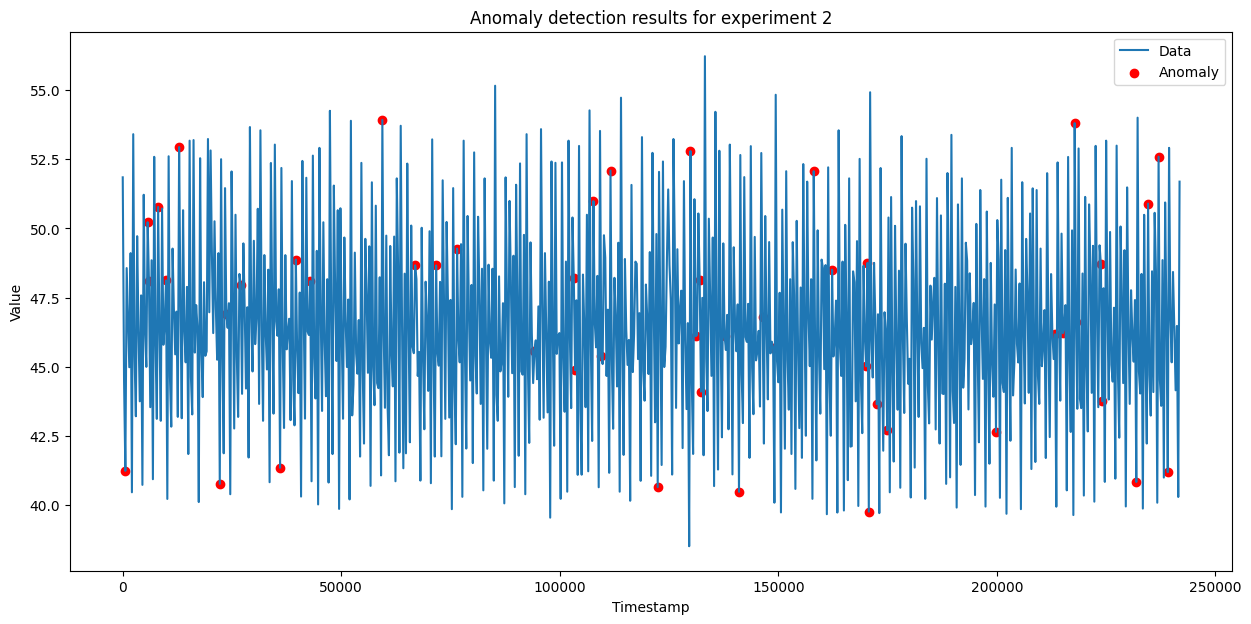

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test_data['timestamp'], test_data['value'], label='Data')
plt.scatter(anomalies_detected2['timestamp'], anomalies_detected2['value'], color='red', label='Anomaly')
plt.legend()
plt.title('Anomaly detection results for experiment 2')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

In [ ]:
Encoder2.save('part3_experiment2_model.h5')


#### EXPERIMENT #3

In [ ]:
### YOUR CODE HERE ###
def dense_lstm_conv1d_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim, 1))
    encoded = LSTM(64, return_sequences=True)(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = LSTM(16, return_sequences=False)(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
    encoded = Conv1D(32, 3, activation='relu', padding='same')(encoded)
    encoded = Flatten()(encoded)
    encoded = Dropout(0.2)(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder


In [ ]:
# run_all_data(dense_lstm_conv1d_autoencoder, 'dense_lstm_conv1d_model')

In [ ]:
Encoder3 = dense_lstm_conv1d_autoencoder( X_train.shape[1])

In [ ]:
Encoder3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
history3 = Encoder3.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0824 - val_loss: 0.0018
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9064e-04 - val_loss: 0.0025
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8719e-04 - val_loss: 0.0022
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4963e-04 - val_loss: 0.0021
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1768e-04 - val_loss: 0.0020
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5372e-04 - val_loss: 0.0024
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5932e-04 - val_loss: 0.0021
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1277e-04 - val_loss: 0.0022
Epoch 12/50
101/101 ━━━━

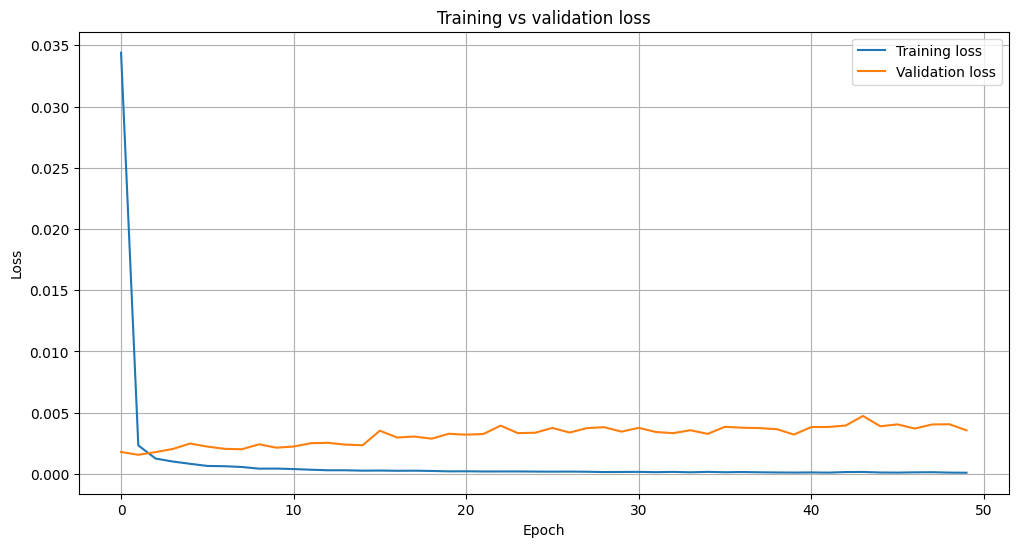

In [ ]:
plot_training_history(history3)

In [ ]:
reconstructed_train = Encoder3.predict(X_train)
mse_train = np.mean(np.power(X_train - reconstructed_train, 2), axis=1)
threshold3 = np.percentile(mse_train, 95)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
mse3, anomalies3 = calculate_anomaly_scores(Encoder3, X_test, threshold3)
print(f"Reconstruction error : {mse3}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Reconstruction error : 0.003564155042188234


In [ ]:
X_test_df = pd.DataFrame(X_test)
test_data = data.iloc[X_test_df.index]
test_data['anomaly'] = anomalies3
anomalies_detected3 = test_data[test_data['anomaly']]


/var/folders/6x/m1j3yfvd2w1cm6zs4szyh4r00000gn/T/ipykernel_53159/2767625774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['anomaly'] = anomalies3


In [ ]:
print(f"Number of anomalies detected: {len(anomalies_detected3)}")
print("\nSample of detected anomalies:")
print(anomalies_detected3.head())
print(f"Anomaly percentage : {len(anomalies_detected3)/len(X_test)}")


Number of anomalies detected: 45

Sample of detected anomalies:
    timestamp   value  anomaly
2       600.0  41.244     True
19     5700.0  50.224     True
27     8100.0  50.774     True
43    12900.0  52.940     True
69    20700.0  46.220     True
Anomaly percentage : 0.055762081784386616


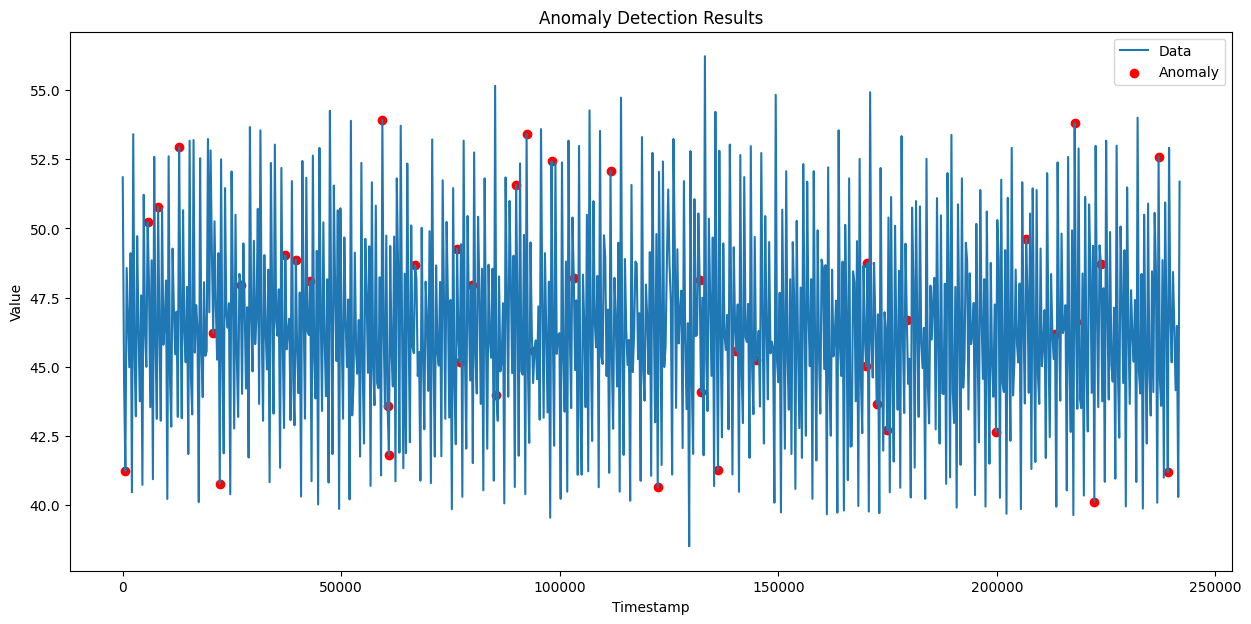

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test_data['timestamp'], test_data['value'], label='Data')
plt.scatter(anomalies_detected3['timestamp'], anomalies_detected3['value'], color='red', label='Anomaly')
plt.legend()
plt.title('Anomaly Detection Results')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

In [ ]:
Encoder3.save('part3_experiment3_model.h5')


In [ ]:
test_data['anomaly'].unique()


array([False,  True])

#### QUESTION 2
Describe the details of your autoencoders, including the layers, activation functions, and any specific configurations employed.

<font color='green'>### YOUR ANSWER HERE ###</font>


The autoencoder we are using will have
1) input layer
2) Encoding layer
3) Decoding layer
4) output layer

In the input layer we use the number of neurons based on the input dimension which is passed in flattened manner.
In encoding layer we have 3 fully connected layers, first layer consists of 64 neurons with Relu activation function. This layer will take the input layer and outputs 64 features as output. We apply dropout of 0.2 to avoid overfitting. We add batch normalizing layer to increase the stability of the model.

The second layer consists of 32 neurons, it reduces the dimension from 64 to 32. It also consists of 0.2 dropout layer and Batch normalizing layer.

The third layer consists of 16 neurons, it reduces the size from 32 to 16. This is known as bottle neck layer which is the reduced version of our input.


We have 2 decoding layers to reconstruct the input, these layers will try to replicate the input with lower dimensions with minimum error.

The first decoding layer will have 32 neurons which will increase the dimensions from 16 to 32. It has Relu activation.
The second decoding layer will have 64 neurons which will increase the dimensions form 32 to 64.

The final output layer will have the same number of neurons as the input which will try to replicate the input by taking 64 neurons from the second decoding layer.



$\textbf{Experiment layer 1}$:

We take input from input layer, we use 1 as we are dealing with time series data.

Encoding layers:
We are using LSTM layers in experiment 1. The first layer consists of 64 neurons, it take the input from input layer and outputs 64 features, it returns full sequence of outputs. It has 0.2 drop out layer.

The second encoding layer has 32 neurons, it reduces the input from 64 to 32 features and it only returns last output in output sequence. It has 0.2 drop out layer.

The 32 neurons is what we call bottle neck to store important features at low dimensions.

We use decoding layers to reconstruct. The first decoding layer has 32 neurons which will expnd the 32 dimensional encoded into 32 dimensional vector.

The second decoding layer will take that 32 features and construct it into 64 features. Then it will be given to the output layer where we construct it into the form of input.






$\textbf{Experiment layer 2}$

This is a Conv1D autoencoder. The input layer will have dimensions of input layer and 1 as it is time series data.
The first encoding layer will have 64 filters of kernel size 3, relu activation function.
The second encoding layer will have 32 filters of kernel size 3 with relu activation.
We then flatten the output to send it to dense layer.

The dense layer has 16 neurons and relu activation. This is the bottle neck layer

The first decoding layer will have 32 times the input sequence with relu activation. We reshape the output into (input, 32).

The second decoding layer will have 64 filters of kernel size 3 with relu activation, this will be given to the ouput layer which will have one filter with kernel size 3.
This layer matches the size of input





$\textbf{Experiment 3}$

This is a hybrid autoencoder with LSTM and Conv1D combined.

The input layer has input dimensions and 1 for time series data.

The first LSTM layer will have 64 neurons it returns the full sequence of outputs. It outputs the 64 dimensional vectors for each time step. It consists of a drop out layer of 0.2.

The second LSTM layer has 16 neurons it returns only the last output sequence. It outputs 16 dimensional vector. It also has a dropout of 0.2

The fist convolutional encoder has 64 filters with kernal size of 3, activation function rely.
This captures the spatial patterns.

The second convolution encoder has 32 filters with kernel of 3 with relu activation. This outputs 32 dimensional vector.

We flatten the output to apply decoding, the 32 dimensional vector is the bottle neck layer. we have a dropout layer of 0.2

In decoding the first dense layer has 32 neurons with relu activation, it expands flattened vector to 32 dimensional representation.
The second dense layer has 64 neurons it expands the dimensions, it has relu activation.
The output layer has input dimensions and linear activation. It reconstructs the input dimensions to match the input.

### **STEP 7:** Evaluate the Models

1. Compare the performance of the different architectures based on the metrics obtained from the validation set.

2. Save the weights of the final model that provides the best results.

3. Evaluate the best model using **the test set**.

4. Report the loss and accuracy on the test set.

5. Generate a confusion matrix using the predictions on the test set.

6. Report other evaluation metrics such as precision, recall and F1 score.

### Model 2 is the best model

In [ ]:
mse2, anomalies2 = calculate_anomaly_scores(Encoder2, X_test, threshold2, squeeze=True)
print(f"reconstruction error : {mse2}")

X_test_df = pd.DataFrame(X_test)
test_data = data.iloc[X_test_df.index]
test_data['anomaly'] = anomalies2
anomalies_detected2 = test_data[test_data['anomaly']]


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
reconstruction error : 5.111424290332346e-06


/var/folders/6x/m1j3yfvd2w1cm6zs4szyh4r00000gn/T/ipykernel_53159/1376807509.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['anomaly'] = anomalies2


In [ ]:
print(f"Number of anomalies detected: {len(anomalies_detected2)}")
print("\nSample of detected anomalies:")
print(anomalies_detected2.head())
print(f"Anomaly percentage : {len(anomalies_detected2)/len(X_test)}")


Number of anomalies detected: 49

Sample of detected anomalies:
    timestamp   value  anomaly
2       600.0  41.244     True
19     5700.0  50.224     True
20     6000.0  48.096     True
27     8100.0  50.774     True
33     9900.0  48.122     True
Anomaly percentage : 0.06071871127633209


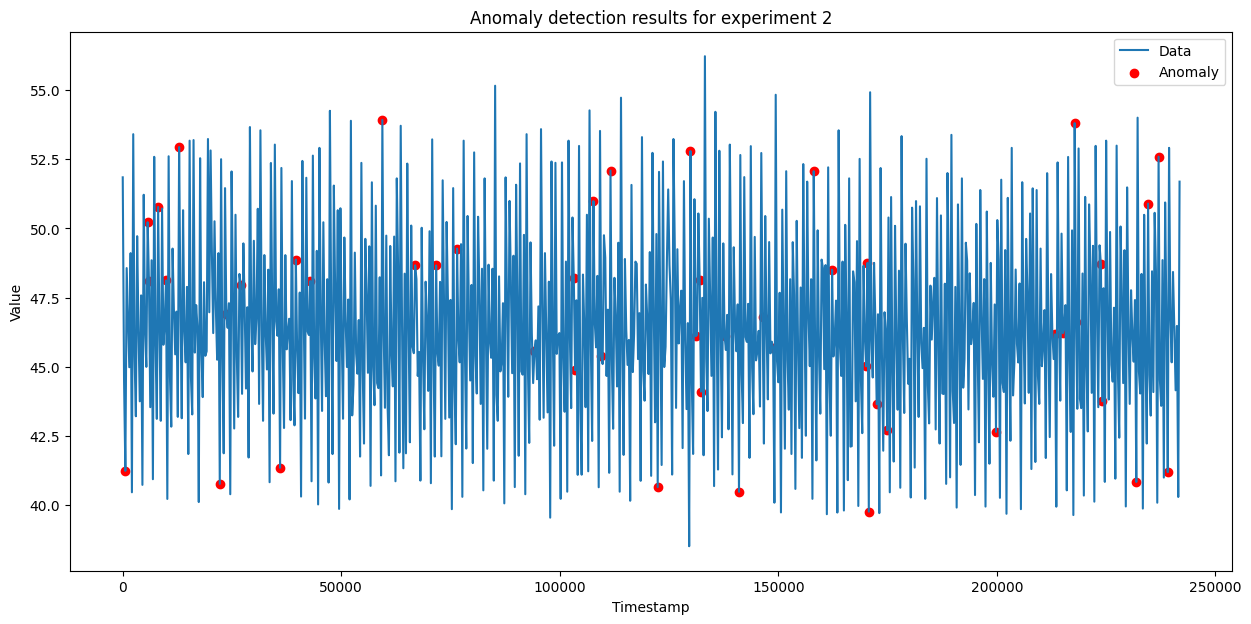

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test_data['timestamp'], test_data['value'], label='Data')
plt.scatter(anomalies_detected2['timestamp'], anomalies_detected2['value'], color='red', label='Anomaly')
plt.legend()
plt.title('Anomaly detection results for experiment 2')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

In [ ]:
Encoder2.save('part3_experiment2_model.h5')


#### QUESTION 3
Discuss the graphs and results obtained from the training and evaluation steps.

<font color='green'>### YOUR ANSWER HERE ###</font>

We have plotted the graphs of training and validation losses while training. The graphs are pretty conventional, for the base model we got decreasing graph for both training loss and validation loss. For experiment 1 and 3 the validation error started low and remained low but the training loss has decreased conventionally. It indicates the sign of overfitting. For the 2nd experimental model both the training and testing were low so this is the best model. so we decided the 2nd experimental model as the best model.

In testing we have plotted the anomalies on the test data. We plotted the anomalies by adding the anomaly column to the dataframe. As this is not the labeled data we can only cluster them but can't get the accuracy.

#### QUESTION 4
Determine which architecture performs best and why (consider factors like reconstruction error and anomaly detection accuracy).

<font color='green'>### YOUR ANSWER HERE ###</font>

base model has mean reconstruction error : 0.0012

experimental model 1 has mean reconstruction error : 0.00087

experimental model 2 has mean reconstruction error as 0.000005

experimental model 3 has mean reconstruction error as 0.0035

So, based on mean reconstruction error, experimental model 2 performs the best.

#### QUESTION 5
Discuss the strengths and limitations of using autoencoders for anomaly detection.

<font color='green'>### YOUR ANSWER HERE ###</font>

Auto encoders Strengths:

1) They don't need any labeled data, they use patterns to reconstruct the input data.
2) We can use the compressed bottle neck layer after getting good reconstruction. This layer has useful information in reduced form.
3) Auto encoders has vast usage, they can be used on images, text and time series analysis.

Weakness:
1) Auto encoders heavily relay on training data. If the training data doesn't cover the complete behaviour then the autoencoder can't detect the anomalies

2) Auto encoders are very sensitive to the choice of parameters. It is difficult to find the optimal parameters by hyper parameter tuning.

3) Interpretability : Similar to many deep learning architectures, autoencoders also difficult to understand. It detects the anomalies but understanding the reason for prediction is difficult

4) There is a high chance of over fitting when we use complex models for simple patterns, so necessary measures must be taken.

## **References**

Include all the references that have been used to complete the assignment.

<font color='green'>### YOUR ANSWER HERE ###</font>

 - https://www.kaggle.com/code/lucfrachon/anomaly-detection-using-vaes
 - https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection
 - https://www.kaggle.com/code/frankmollard/a-story-about-unsupervised-learning
 - https://www.kaggle.com/code/joshuaswords/time-series-anomaly-detection
 - https://www.kaggle.com/code/emailshyams/starter-numenta-anomaly-benchmark-e4ee7b3f-4
 - https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5
 - https://www.analyticsvidhya.com/blog/2023/09/variational-autoencode-for-anomaly-detection-using-tensorflow/
 - https://towardsdatascience.com/uncovering-anomalies-with-variational-autoencoders-vae-a-deep-dive-into-the-world-of-1b2bce47e2e9
 - https://datascience.stackexchange.com/questions/89722/1d-cnn-variational-autoencoder-conv1d-size
 - https://stackoverflow.com/questions/49290895/how-to-implement-a-1d-convolutional-auto-encoder-in-keras-for-vector-data
 - https://gist.github.com/nemanja-rakicevic/551763a6a28149972caccadaafe3bacb